# BlackJack

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch    # draw shapes
import numpy as np
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from IPython.display import clear_output

In [2]:
env = gym.make('Blackjack-v1', sab = True, render_mode = 'rgb_array')   # create an environment 

In [3]:
# Observe environment  Episode: Start to End
# reset the environment to the initial observation
done = False
observation, info = env.reset()   # observation: (player_sum, dealer_card, usable_ace) usabel_ace: When it counts as 11 without busting 
print('Initial observation:', observation)


Initial observation: (20, 3, 0)


# Execute an action
Randomly samples an action from the action space.

Takes a step in the environment based on the chosen action.

Prints the next observation, reward received, and whether the episode terminated.

In [4]:
action = env.action_space.sample()   # sample an action from the action space
observation, reward, terminated, truncated, info = env.step(action)   # take a step in the environment
print('Next observation:', observation)
print('Reward:', reward)
print('Terminated:', terminated)

Next observation: (20, 3, 0)
Reward: 0.0
Terminated: True


### Explanation: BlackJaclAgent

**Initialization (`__init__` method):**

Initializes the agent with the following parameters:
- `learning_rate`: The learning rate for updating Q-values.
- `initial_epsilon`: Initial exploration rate for the epsilon-greedy policy.
- `epsilon_decay`: Rate at which exploration decreases over time.
- `final_epsilon`: Minimum exploration rate.
- `discount_factor`: Discount factor for calculating expected return (Q-value).

**`get_action` Method:**

Chooses an action based on the epsilon-greedy policy.
- With probability `epsilon`, it explores by selecting a random action.
- Otherwise, it exploits by choosing the action with the highest Q-value for the current state.

**`update` Method:**

Updates the state-action value based on the observed reward and the next observation.
- Calculates the temporal difference, representing the difference between the observed reward and the expected future rewards.
- Updates the Q-value for the current state-action pair using the learning rate and temporal difference.
- Appends the temporal difference to the `training_error` list for monitoring.

**`decay_epsilon` Method:**

Decays the epsilon value over time.
- Ensures that the agent gradually shifts from exploration to exploitation.

The `BlackjackAgent` class implements a simple Q-learning algorithm with an epsilon-greedy policy. The agent learns to make decisions in the Blackjack environment by updating its Q-values based on observed rewards and transitions between states. The epsilon value decreases over time, leading to a balance between exploration and exploitation during training.


In [5]:
# if terminated is True, the episode is over

# build a agent
class BlackjackAgent:
    def __init__(
            self, 
            learning_rate:float, 
            initial_epsilon:float, 
            epsilon_decay:float, 
            final_epsilon:float, 
            discount_factor:float = 0.95):
        """
        Initialize a RL agent with empty dictionary of state-action value

        discount_factor: The discount factor for calculating the expected return (q-value)
        """
 
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr= learning_rate
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = discount_factor
        self.training_error = []

    def get_action(self, obs:tuple[int, int, bool])->int:
        """
        Choose an action based on the epsilon-greedy policy; return the best action with probability 1-epsilon 

        """
        if np.random.rand() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
    
    def update(self, obs:tuple[int, int, bool], action:int, reward:float, terminated:bool, next_obs:tuple[int, int, bool]): 
        """
        Update the state-action value based on the observed reward and next observation
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])

        self.q_values[obs][action] += self.lr * temporal_difference  
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """
        Decay the epsilon value
        """
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

#### Q-value: Is used to determine the optimal action-selection policy for any given state. Maximize the expected value of the total reward

In [6]:
# train the agent
learning_rate = 0.01
n_episodes = 1000
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (n_episodes/2) # decay the epsilon to 0.5 after half of the episodes
final_epsilon = 0.1

agent = BlackjackAgent(learning_rate, initial_epsilon, epsilon_decay, final_epsilon)

# Training the Agent
The agent is trained through a series of episodes. Within each episode, the agent interacts with the environment, selects actions based on its policy, and updates its Q-values based on the observed rewards and next states.

## Epsilon-Greedy Policy
The agent follows an epsilon-greedy policy, where it explores with probability epsilon and exploits (chooses the action with the highest Q-value) with probability 1 - epsilon.

## Q-Value Update
The Q-values are updated using the temporal difference (TD) error, which is the difference between the observed reward and the expected future rewards.

Episode: 999 Total Episodes: 1000
reward: -1.0 terminated: True truncated: False info: {'episode': {'r': array([-1.], dtype=float32), 'l': array([1]), 't': array([0.], dtype=float32)}}


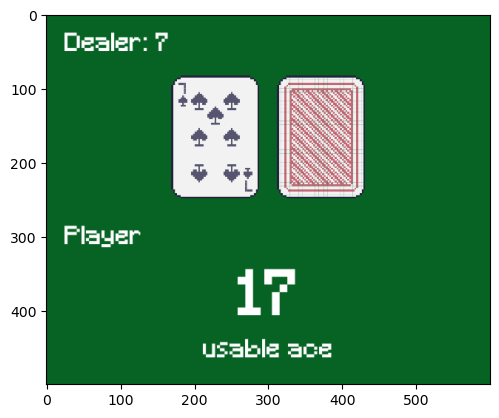

100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


In [7]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size = n_episodes)   # record the episode statistics
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    clear_output()
    print('Episode:', episode, 'Total Episodes:', n_episodes)
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, action, reward, terminated, next_obs)
        frame = env.render()
        print('reward:', reward, 'terminated:', terminated, 'truncated:', truncated, 'info:', info)
        plt.imshow(frame)
        plt.show()
        done = terminated or truncated
        obs = next_obs
    agent.decay_epsilon()


### Rolling Length:

`rolling_length` is set to 500, representing the window size for calculating moving averages.

### Subplots:

`plt.subplots(ncols=3, figsize=(12, 5))` creates a figure with 3 subplots in a single row, each with a specified size.

### Plotting Episode Rewards:

Calculates the moving average of episode rewards and plots it in the first subplot.

### Plotting Episode Lengths:

Calculates the moving average of episode lengths and plots it in the second subplot.

### Plotting Training Error:

Calculates the moving average of training errors and plots it in the third subplot.

### Display:

`plt.show()` displays the overall figure containing all three subplots.

This code generates a visual representation of the moving averages of episode rewards, episode lengths, and training errors over time, providing insights into the agent's performance during training.


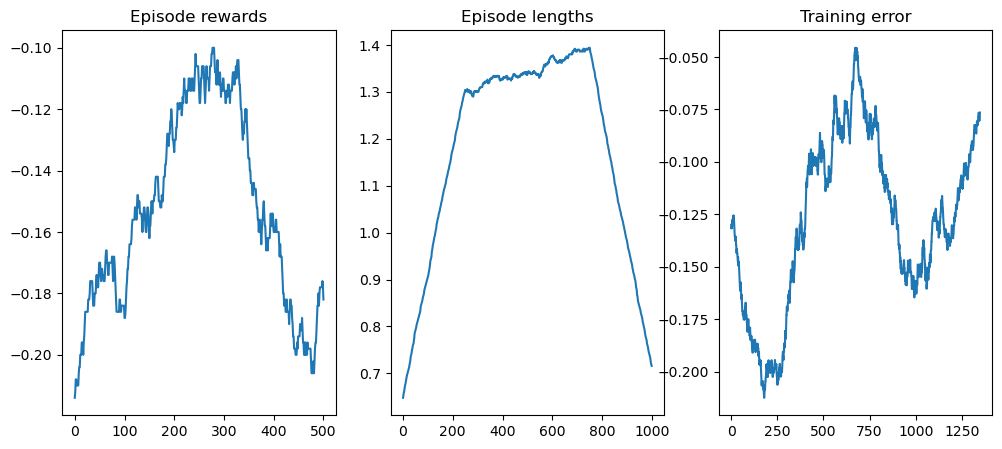

In [8]:
# Plotting
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = (np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same") / rolling_length)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training error")
error_moving_average = (np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length)
axs[2].plot(range(len(error_moving_average)), error_moving_average)
plt.show()
